In [29]:
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt
import math
from types import new_class

%matplotlib inline
plt.style.use("ggplot")

In [30]:
import yfinance as yf

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return data.pct_change()

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Read Portfolios and trading Strategies

In [31]:
%run -i 'portfolio.py'

# BenchMark Portfolio

Choosing the following ETFs for each asset class:
<table>
    <th>
        <td>Ticker</td>
        <td>Weight</td>
        <td>Ticker Description</td>
    </th>
    <tr>
        <td>US Market</td>
        <td><b>SPY</b></td>
        <td>30%</td>
        <td>S&P 500 ETF</td>
    </tr>
    <tr>
        <td>International Markets (ex. US)</td>
        <td><b>ACWX</b></td>
        <td>25%</td>
        <td>MSCI Asian/Emerging Markets ex U.S. ETF</td>
    </tr>
    <tr>
        <td>US Bonds</td>
        <td><b>SCHO</b></td>
        <td>20%</td>
        <td>Schwab Short Term US Treasury ETF</td>
    </tr>
    <tr>
        <td>International Bonds</td>
        <td><b>BNDX</b></td>
        <td>15%</td>
        <td>Vanguard Total International Bond Index Fund ETF Shares</td>
    </tr>
    <tr>
        <td>Other Asset Classes</td>
        <td><b>USO</b></td>
        <td>10%</td>
        <td>United States Oil Fund, LP</td>
    </tr>
</table>

In [13]:
portfolio_tickers = ["SPY","ACWX","SCHO","BNDX","USO"]
weights = pd.Series([0.30, 0.25, 0.20, 0.15, 0.10], index= portfolio_tickers)
weights

SPY     0.30
ACWX    0.25
SCHO    0.20
BNDX    0.15
USO     0.10
dtype: float64

[*********************100%***********************]  5 of 5 completed


,ACWX,BNDX,SCHO,SPY,USO
Date,,,,,
2013-06-04,34.427269,42.735859,46.265095,139.147415,265.600006
2013-06-05,33.852001,42.786812,46.255959,137.199295,266.079987
2013-06-06,34.003807,42.727371,46.265095,138.441345,268.959991
2013-06-07,34.291428,42.642406,46.255959,140.202393,273.279999
2013-06-10,34.267467,42.336544,46.246796,140.202393,272.000000


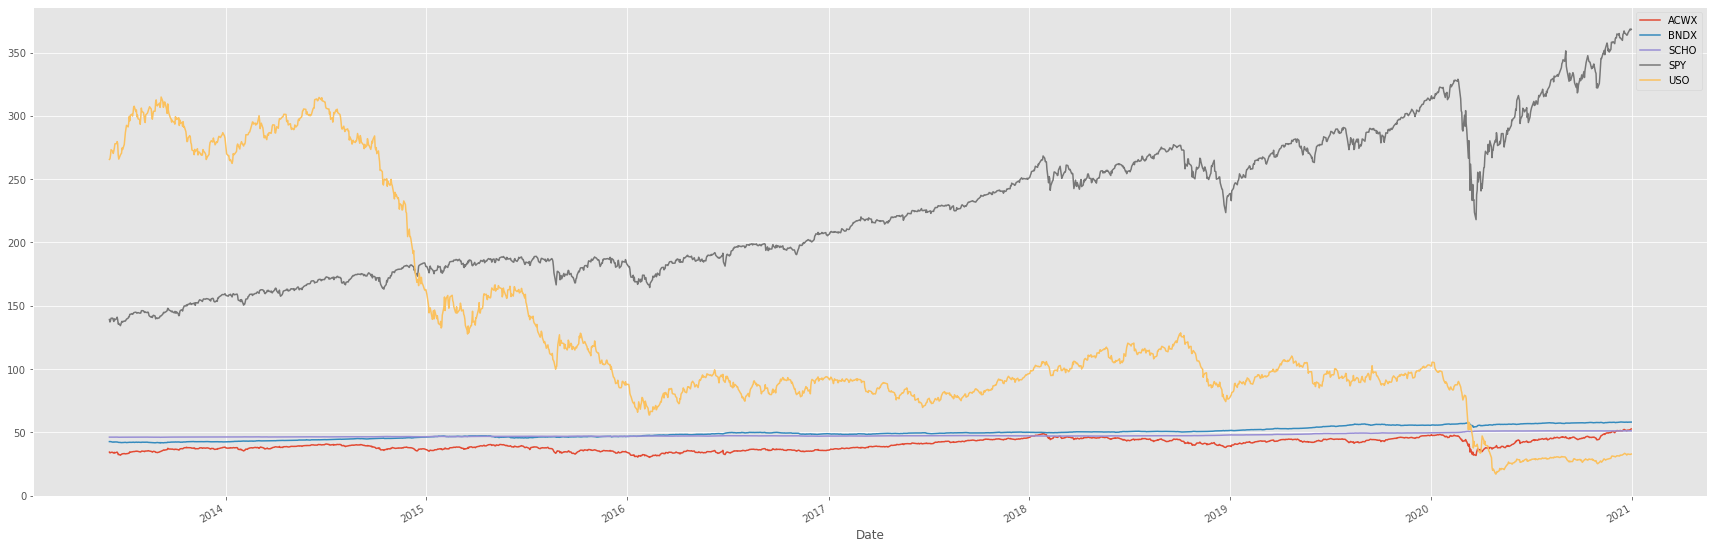

In [14]:
benchmark_data = yf.download("SPY ACWX SCHO BNDX USO", start="2010-01-01", end="2020-12-31")["Adj Close"].dropna()
# benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.plot(figsize = (30,10))
benchmark_data.head()

# Benchmark Portfolio

In [19]:
# class TradingAlgo():
#     def __init__(self, name: str) -> None:
#         self.identifier = name
#         return
    
# class mSNP500_Algo(type(TradingAlgo)):
#     pass

# class SNP500_Algo(TradingAlgo):
#     def run(self):
#         print(self.identifier)
#         return "Hello World"

In [2]:
import importlib
module = __import__("trading_algo")
class_ = getattr(module, "trial_algo")
instance = class_(name="Trial")
instance.run()

Trial


'Hello World'

In [15]:
from types import new_class

trial = new_class("sample", (object,), {"metaclass": sample}, lambda ns: ns)
type(trial)

Hello World


# S&P 500 Replicating Portfolio

## Read S&P 500 Index Constituent Data

- WRDS Method _(includes historical data)_

In [ ]:
spy_ticker_data = pd.read_csv("./data/sp500_constituents.csv")
spy_ticker_set = set(spy_ticker_data["Symbol"])
print("Unique Indices:",len(spy_ticker_set))
spy_ticker = dict()
for year in spy_ticker_data["Year"].unique():
    spy_ticker[year] = list(spy_ticker_data[spy_ticker_data["Year"] == year]["Symbol"])
# spy_ticker

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [135]:
spy_dataframe = data[data["datadate"] >= pd.to_datetime("01-01-2010")]

# Temporay measure b/c our spy_ticker does not have 2021 data
spy_dataframe = data[data["datadate"] <= pd.to_datetime("01-01-2021")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

Number of unique tickers: 1190
Dimensions:  (2183146, 5)
datadate        0
tic             0
div             0
shares      49497
close         553
dtype: int64


,datadate,tic,div,shares,close
5592,2010-01-13,Z.1,0.1546,NaN,NaN
8973,2010-01-20,RRD.2,0.2721,NaN,NaN
12443,2010-01-27,5050B,0.1950,NaN,NaN
20504,2010-02-10,0051B,0.1250,NaN,NaN
20505,2010-02-10,0050B,0.0730,NaN,NaN
...,...,...,...,...,...
2141545,2020-10-15,Z.1,0.1983,NaN,NaN
2142940,2020-10-16,PLP.Z,0.5671,NaN,NaN
2165919,2020-11-30,6525B,0.4005,NaN,NaN
2173465,2020-12-14,AHC.2,0.3187,NaN,NaN


**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [136]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

datadate        0
tic             0
div             0
shares      48944
close           0
dtype: int64


In [137]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

div        shares   close
datadate   tic                              
2010-01-04 AAMRQ   0.0  3.324560e+08    7.72
           MRO     0.0  7.078450e+08   32.11
           PCS     0.0  3.524010e+08    7.97
           LOW     0.0  1.472032e+09   23.16
           GOOGL   0.0  2.429990e+08  626.75
...                ...           ...     ...
2020-12-31 EXR     0.0  1.292350e+08  115.86
           AON     0.0  2.286160e+08  211.27
           BAC.PM  0.0  5.590000e+07   27.31
           MSI     0.0  1.695230e+08  170.06
           L       0.0  2.748730e+08   45.02

[2182593 rows x 3 columns]

In [222]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [397]:
;
%run -i 'portfolio.py'

<Figure size 432x288 with 0 Axes>

In [398]:
spy_trading_algo = SNP500_Algo("S&P 500 Algo")
spy_portfolio = Portfolio(target="S&P 500",
                        tickerset= spy_ticker, investment= 1000000,
                        trading_algo= spy_trading_algo,
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Target Index: S&P 500
Trading Algorithm: S&P 500 Algo
Starting Investment: 1000000
Current Investment: 1000000


In [399]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = spy_data.loc[date,:]
    valuation, returns =  spy_portfolio.run(date= date, price= tmpdf, tickerlist = spy_ticker[date.year])
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010
	Rebalancing on: 05-Jan-2010
	Rebalancing on: 06-Jan-2010
	Rebalancing on: 07-Jan-2010
	Rebalancing on: 08-Jan-2010
	Rebalancing on: 11-Jan-2010
	Rebalancing on: 12-Jan-2010
	Rebalancing on: 13-Jan-2010
	Rebalancing on: 14-Jan-2010
	Rebalancing on: 15-Jan-2010
	Rebalancing on: 19-Jan-2010
	Rebalancing on: 20-Jan-2010
	Rebalancing on: 21-Jan-2010
	Rebalancing on: 22-Jan-2010


<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Rebalancing on: 25-Jan-2010
	Rebalancing on: 26-Jan-2010
	Rebalancing on: 27-Jan-2010
	Rebalancing on: 28-Jan-2010
	Rebalancing on: 29-Jan-2010
	Rebalancing on: 01-Feb-2010
	Rebalancing on: 02-Feb-2010
	Rebalancing on: 03-Feb-2010
	Rebalancing on: 04-Feb-2010
	Rebalancing on: 05-Feb-2010
	Rebalancing on: 08-Feb-2010
	Rebalancing on: 09-Feb-2010
	Rebalancing on: 10-Feb-2010
	Rebalancing on: 11-Feb-2010
	Rebalancing on: 12-Feb-2010
	Rebalancing on: 16-Feb-2010
	Rebalancing on: 17-Feb-2010
	Rebalancing on: 18-Feb-2010
	Rebalancing on: 19-Feb-2010
	Rebalancing on: 22-Feb-2010
	Rebalancing on: 23-Feb-2010
	Rebalancing on: 24-Feb-2010
	Rebalancing on: 25-Feb-2010
	Rebalancing on: 26-Feb-2010
	Rebalancing on: 01-Mar-2010
	Rebalancing on: 02-Mar-2010
	Rebalancing on: 03-Mar-2010
	Rebalancing on: 04-Mar-2010
	Rebalancing on: 05-Mar-2010
	Rebalancing on: 08-Mar-2010
	Rebalancing on: 09-Mar-2010
	Rebalancing on: 10-Mar-2010
	Rebalancing on: 11-Mar-2010
	Rebalancing on: 12-Mar-2010
	Rebalancing o

In [400]:
spy_portfolio.echo()
# print("Net return since start: ",spy_portfolio.net_return()*100,"%")

Target Index: S&P 500
Trading Algorithm: S&P 500 Algo
Starting Investment: 1000000
Current Investment: 3081413.6985582802
Constituent Indices: MMM, ABT, ABBV, ABMD, ACN ...
Constituent Weights: tic
JKHY     7.093611
ALL     28.263277
WRB     16.565733
FISV    62.317556
HON     65.222074
dtype: float64


In [401]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns.fillna(1)+1)-1)*100,"%")

daily return:  0.0389266495835372 %


## S&P Index, ETF and Mutual Fund

In [410]:
benchmark_data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2020-12-31")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,113.330002,104.320000,1132.989990
2010-01-05,113.629997,104.650002,1136.520020
2010-01-06,113.709999,104.750000,1137.140015
2010-01-07,114.190002,105.180000,1141.689941
2010-01-08,114.570000,105.480003,1144.979980


In [411]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.002647,0.003163,0.003116
2010-01-06,0.000704,0.000956,0.000546
2010-01-07,0.004221,0.004105,0.004001
2010-01-08,0.003328,0.002852,0.002882


## Plot

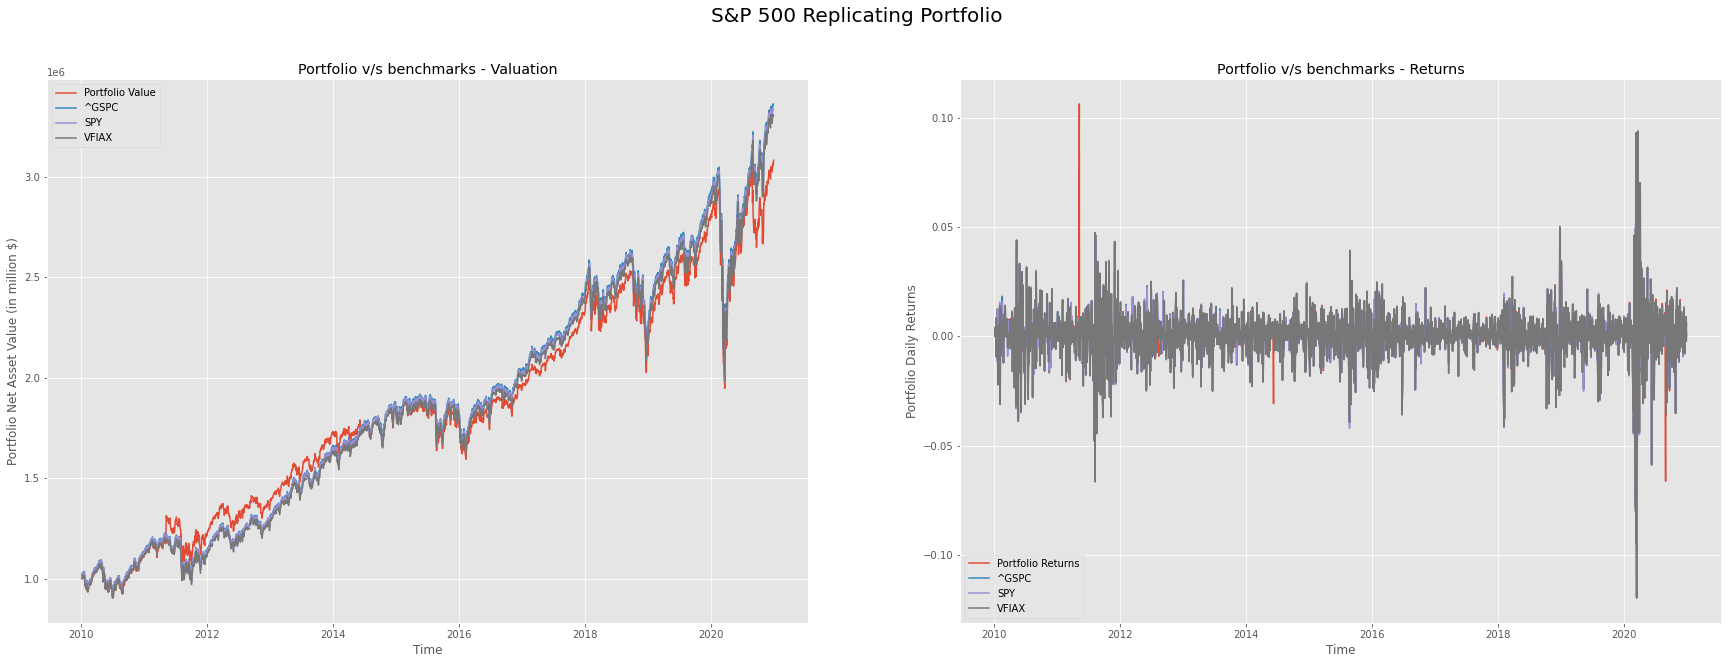

In [412]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot(benchmark_data["^GSPC"]*900)
ax[0].plot(benchmark_data["SPY"]*8961.3)
ax[0].plot(benchmark_data["VFIAX"]*9600)
ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^GSPC"])
ax[1].plot(baseline_return["SPY"])
ax[1].plot(baseline_return["VFIAX"])
ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

In [413]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and SPY is 0.267%
Tracking error between our portfolio and VFIAX is 0.328%
Tracking error between our portfolio and ^GSPC is 0.253%


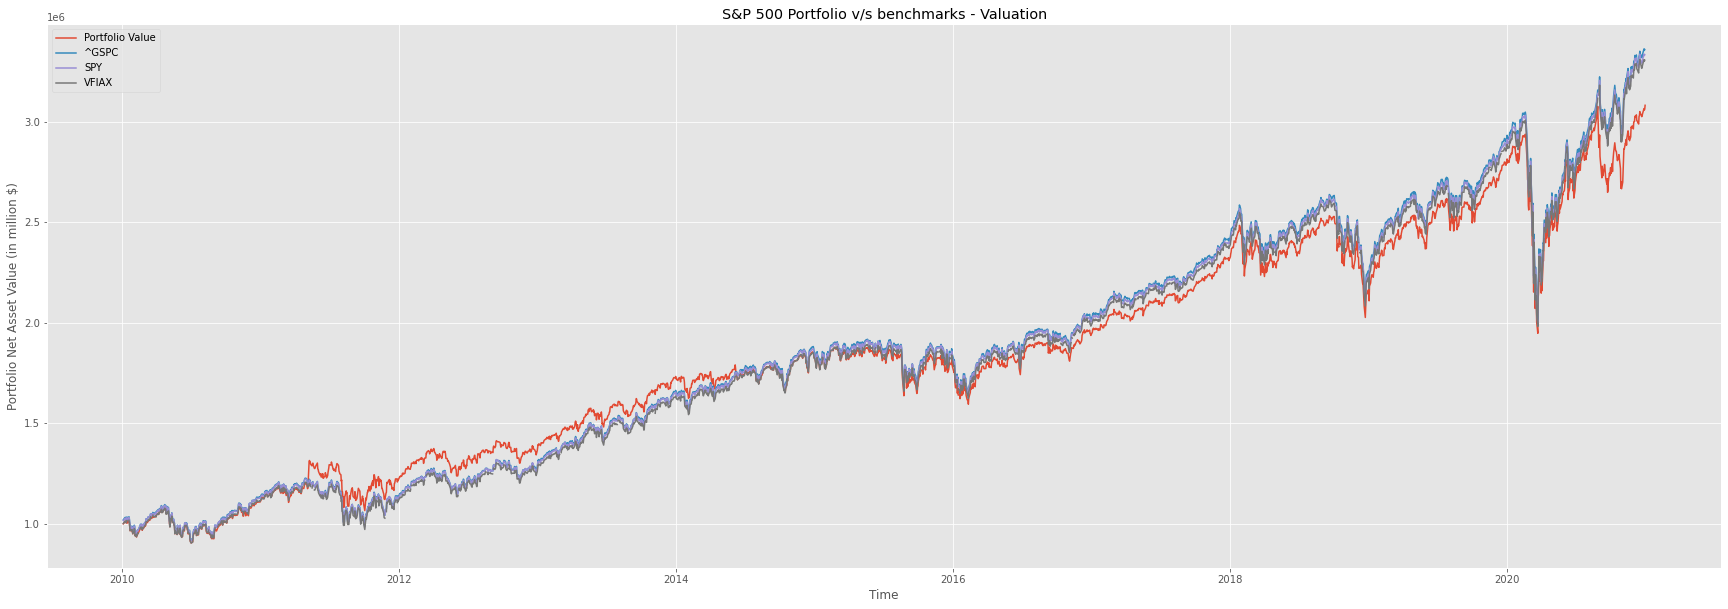

In [414]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot(benchmark_data["^GSPC"]*900)
plt.plot(benchmark_data["SPY"]*8961.3)
plt.plot(benchmark_data["VFIAX"]*9600)
plt.legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("S&P 500 Portfolio v/s benchmarks - Valuation")
plt.show()

# DJIA Replicating Portfolio

## Fetch DJIA Index Constituent Data

In [ ]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
# driver.get(url)

# def get_text(x):
#     return x.text

In [ ]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[2]/a'
# djia_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     djia_ticker_set.add(get_text(item))
# print(len(djia_ticker_set))
# driver.close()
# # djia_ticker_set

In [ ]:
# with open('./data/djia_ticker.txt', 'w') as f:
#     for item in djia_ticker_set:
#         f.write("%s\n" % item)

## Read DJIA Index Constituent Data

- Wikipedia Method

In [ ]:
# djia_ticker_set = set()
# with open('./data/djia_ticker.txt') as f:
#     djia_ticker_set = f.readlines()
#     djia_ticker_set = {x.strip() for x in djia_ticker_set}
# print(len(djia_ticker_set))

- WRDS Method _(includes historical data)_

In [ ]:
djia_ticker_data = pd.read_csv("./data/dj_constituents.csv")
djia_ticker_set = set(djia_ticker_data["Symbol"])
print("Unique Indices:",len(djia_ticker_data))
djia_ticker = dict()
for year in djia_ticker_data["Year"].unique():
    djia_ticker[year] = list(djia_ticker_data[djia_ticker_data["Year"] == year]["Symbol"])
djia_ticker

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [ ]:
djia_dataframe = data[data["tic"].apply(lambda x: (x in djia_ticker_set))].copy()
djia_dataframe = djia_dataframe[djia_dataframe["datadate"] >= pd.to_datetime("01-01-2010")]
print("Number of unique tickers:",len(djia_dataframe.tic.value_counts()))
djia_data = djia_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",djia_data.shape)
print(djia_data.isna().sum())
djia_data[np.isnan(djia_data.close)]

In [ ]:
djia_data = djia_data.set_index(["datadate","tic"])
djia_data

In [ ]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],djia_data.index.values))))
market_calendar_dates[0:5]

## Executing Portfolio

In [ ]:
# ;
# %run -i 'portfolio.py'

In [ ]:
djia_trading_algo = DJIA_Algo("Dow Jones Algo")

djia_portfolio = Portfolio(target="DJIA",
                        tickerlist= list(djia_ticker_set), investment= 1000000,
                        trading_algo= djia_trading_algo,
                        rebalance=1, reconstitute=12)

# djia_portfolio.echo()

In [ ]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = djia_data.loc[date,:]

    valuation, returns =  djia_portfolio.run(date= date, price= tmpdf)
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
    # print(date.strftime("%d-%m-%Y"), valuation, returns)

In [ ]:
djia_portfolio.echo()
# print("Net return since start: ",djia_portfolio.net_return()*100,"%")

In [ ]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

## DJIA Index, ETF and Mutual Fund(Not yet available)

In [ ]:
benchmark_data = yf.download("^DJI DIA VTSMX", start="2010-01-01", end="2021-10-07")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

In [ ]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

## Plot

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot((benchmark_data["^DJI"]-584)*100)
ax[0].plot((benchmark_data["DIA"]-5.66)*10000)
ax[0].plot(benchmark_data["VTSMX"]*30000 + 162700)
ax[0].legend(["Portfolio Value","^DJI","DIA","VTSMX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^DJI"])
ax[1].plot(baseline_return["DIA"])
ax[1].plot(baseline_return["VTSMX"])
ax[1].legend(["Portfolio Returns","^DJI","DIA","VTSMX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

In [ ]:
tracking_error_djia = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_djia.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot((benchmark_data["^DJI"]-584)*100)
plt.plot((benchmark_data["DIA"]-5.66)*10000)
plt.plot(benchmark_data["VTSMX"]*30000 + 162700)
plt.legend(["Portfolio Value","^DJI","DIA","VTSMX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("DJIA Portfolio v/s benchmarks - Valuation")
plt.show()

***
***